## 撰寫網路爬蟲爬取Yahoo 電影評論

In [2]:
import requests
from bs4 import BeautifulSoup
res = requests.get('https://movies.yahoo.com.tw/movieinfo_review.html/id=10240')
soup = BeautifulSoup(res.text, 'lxml')

In [17]:
ary = []
for com in soup.select('.usercom_list li'):
    comment = com.select('span')[2].text
    stars = com.select_one('input[name="score"]').get('value')
    ary.append({'comment':comment, 'stars':stars})

In [18]:
import pandas
df = pandas.DataFrame(ary)

In [19]:
df

,comment,stars
0,頭一次覺得得獎又超好看的！\r\n是自己心目中今年第一名的國片\r\n很值得進戲院,5
1,最多最多三顆星。不用花錢進來看,3
2,本來只想著支持金馬獎的心情去看，沒想到超級好看!!!!!一開始就有爆點~~~從頭到尾真的沒有...,5
3,不懂評論裡的五顆星是怎麼一回事，邊看邊覺得尷尬癌上身，畫面很美但剪接零碎的讓人出戲，人物刻畫...,1
4,得獎實至名歸 很久沒進戲院了 看完後覺得值回票價 難得的好片,5
5,很好看！最佳劇情長片實至名歸！值得進戲院支持,5
6,家庭真的是很難，或許也很簡單。,5
7,很棒的電影，值得一看再看的好戲！,5
8,社會寫實面，很值得看的國片!!,5
9,很寫實的劇情，確實會是發生在家中的每一個角落\r\n片長158分鐘，確毫無冷場,5


## 讀取Yahoo 電影評論 

In [22]:
import pandas
df = pandas.read_excel('https://raw.githubusercontent.com/ywchiu/pytextmining/master/data/yahoo_movie.xlsx', index_col = 0)

In [23]:
df.head()

,content,stars,title,status
0,"不知道耶! 看完整個無感\r\n有種覺得就是女兒""給蕭""害死了老爸\r\n然後...既然可以...",3,古墓奇兵,soso
1,很好看的動作片，不會浪費錢跟時間。很久沒有這樣的探險片。可說是女版的印第安那瓊。女主角跟爸爸...,5,古墓奇兵,good
2,說這個不好看的話，那我還真不知道，還有什麼片是您可以去看得了。電影好看，但話說羅拉有裝可以撿...,5,古墓奇兵,good
3,父女重逢真的很讓人感動，五顆星。,5,古墓奇兵,good
4,劇情雖然老套，但仍拍出新意，古墓能殺人的方式不就是機關和毒，要求亂七八糟的觀眾，你看喪尸片看多了。,4,古墓奇兵,good


In [25]:
df['title'].unique()

array(['古墓奇兵', '最後的絕地武士', '攻殼機動隊', '奧創紀元', '最終騎士'], dtype=object)

In [28]:
import jieba
corpus = []
tags = []
for idx, rec in df[df['status'].isin(['good', 'bad'])].iterrows():
    corpus.append(' '.join(jieba.cut(rec['content'])))
    tags.append(rec['status'])

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/46/b7dzk4mn6g54qzptv608w7d00000gn/T/jieba.cache
Loading model cost 0.806 seconds.
Prefix dict has been built succesfully.


In [29]:
corpus[0]

'很 好看 的 動作片 ， 不會 浪費 錢 跟 時間 。 很 久 沒有 這樣 的 探險 片 。 可 說 是 女版 的 印第安那 瓊 。 女 主角 跟 爸爸 還 有 反派 都 演 得到 位 。 陸任 的 男 配角 常 在 港片 看到 ， 很帥 。 一時 忘了 名字 。 希望 有 續集 。'

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

In [31]:
X.shape

(980, 4839)

In [32]:
len(tags)

980

In [33]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, tags, test_size = 0.3, random_state = 42)

In [34]:
train_X.shape

(686, 4839)

In [35]:
test_X.shape

(294, 4839)

In [36]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha = 0.01)
clf.fit(train_X, train_y)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [37]:
predicted = clf.predict(test_X)

In [41]:
(predicted == test_y).sum() / len(predicted)

0.7687074829931972

In [42]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(test_y, predicted)

0.7687074829931972

In [44]:
print(clf.classes_)

['bad' 'good']


In [43]:
confusion_matrix(test_y, predicted)

array([[ 82,  35],
       [ 33, 144]])

In [46]:
import operator
coef_features_c1_c2 = []

for index, features in enumerate(zip(vectorizer.get_feature_names(), \
                        clf.feature_count_[0], clf.feature_count_[1])):
    feat,c1,c2 = features
    coef_features_c1_c2.append(tuple([c1/(c2 + 1), feat, c1, c2]))

for i in sorted(coef_features_c1_c2, key = operator.itemgetter(0), reverse=True)[0:20]:
    print(i)


(6.672863530338025, '睡著', 10.800754416632653, 0.6186086179534868)
(4.823810509851034, '浪費', 7.204200091270568, 0.49346664355044145)
(4.058824255401444, '爛片', 7.2666613024304265, 0.7903365223956232)
(3.6956875803437925, '看到', 13.897332511559544, 2.760418652668346)
(3.4692918154989485, '睡覺', 4.362408041695186, 0.2574347370279635)
(3.2563387106676434, '失望', 7.196320060507634, 1.2099421159515005)
(3.184964059891438, '演什麼', 3.184964059891438, 0.0)
(2.6264409387388845, '只有', 4.606838953575162, 0.7540234336231402)
(2.2930874637087633, '空洞', 3.1738043456202947, 0.3840747009654352)
(2.17199793254736, '五集', 2.3499882879130665, 0.08194775542762894)
(2.1053163150222374, '四集', 2.1053163150222374, 0.0)
(2.021695889662221, '亂七八糟', 2.529498271257764, 0.25117644260551225)
(1.9198916259333108, '爛透', 1.9198916259333108, 0.0)
(1.9147255861808632, '超爛', 1.9147255861808632, 0.0)
(1.8322298165070485, '難看', 11.96566093557524, 5.530655067270165)
(1.764198580729871, '小時', 2.941518804755412, 0.6673399677821239)


In [59]:
s = '很好看！最佳劇情長片實至名歸！值得進戲院支持'
seg_corpus = [' '.join(jieba.cut(s))]

In [60]:
predict_X = vectorizer.transform(seg_corpus)

In [61]:
clf.predict(predict_X)

array(['good'], dtype='<U4')

## Wordnet

In [62]:
import nltk

In [63]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/davidchiu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [64]:
from nltk.corpus import wordnet as wn
wn.synsets('motorcar')
#wn.synsets('trunk’)


[Synset('car.n.01')]

In [66]:
wn.synsets('trunk')

[Synset('trunk.n.01'),
 Synset('trunk.n.02'),
 Synset('torso.n.01'),
 Synset('luggage_compartment.n.01'),
 Synset('proboscis.n.02')]

In [67]:
wn.synset('car.n.01').lemma_names()

['car', 'auto', 'automobile', 'machine', 'motorcar']

## 計數手法

In [70]:
text = 'You say goodbye and I say hello .'
words = text.lower().split()


In [72]:
word_to_id = {}
id_to_word = {}
for idx, w in enumerate(set(words)):
    word_to_id[w] = idx
    id_to_word[idx] = w

In [73]:
word_to_id

{'.': 0, 'say': 1, 'and': 2, 'goodbye': 3, 'i': 4, 'hello': 5, 'you': 6}

In [74]:
id_to_word

{0: '.', 1: 'say', 2: 'and', 3: 'goodbye', 4: 'i', 5: 'hello', 6: 'you'}

In [87]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)



In [88]:
corpus, word_to_id, id_to_word

(array([0, 1, 2, 3, 4, 1, 5, 6]),
 {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6},
 {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'})

In [89]:
import numpy as np
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix



In [91]:
C =create_co_matrix(corpus, len(word_to_id), 1)

In [95]:
from sklearn.metrics.pairwise import cosine_similarity
C[0]
C[1]

array([1, 0, 1, 0, 1, 1, 0], dtype=int32)

In [97]:
cosine_similarity(C)[0]

array([1.        , 0.        , 0.70710678, 0.        , 0.70710678,
       0.70710678, 0.        ])

In [99]:
C2 =create_co_matrix(corpus, len(word_to_id), 2)

In [100]:
C2

array([[0, 1, 1, 0, 0, 0, 0],
       [1, 0, 1, 2, 1, 1, 1],
       [1, 1, 0, 1, 1, 0, 0],
       [0, 2, 1, 0, 1, 0, 0],
       [0, 1, 1, 1, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 0, 0, 1, 0]], dtype=int32)

In [115]:
def most_similar(term, word_to_id, id_to_word, C, top=5):
    cs = cosine_similarity(C)
    ranks = cs[word_to_id[term]].argsort()[::-1][1:top+1]
    for rank in ranks:
        print(id_to_word[rank],cs[word_to_id[term]][rank])
    #return cs[word_to_id[term]].argsort()[::-1][1:top]

In [116]:
most_similar('you', word_to_id, id_to_word, C, top=5)


hello 0.7071067811865475
i 0.7071067811865475
goodbye 0.7071067811865475
. 0.0
and 0.0


In [117]:
text = '''
Tesla's new Cybertruck smashed during demo
Tesla has unveiled its "Cybertruck" pickup truck, but not without an embarrassing moment on stage.

The truck's windows were smashed during a demonstration supposed to show how hard they were to break.

Mr Musk was heard to swear before joking: "Room for improvement."

The truck was unveiled in Hawthorne, California, where its stainless steel, angular design was greeted with cheers but also bemusement.

"People probably won’t get past the looks of it," said Jessica Caldwell, from vehicle marketplace Edmunds.

"It looks like a truck version of the DeLorean from Back To The Future."

The pickup market represents a significant opportunity for Tesla as it improves its battery technology, meaning carrying heavier loads over long distances is now practical.
According to Edmunds, large trucks have accounted for 14.4% of new vehicle sales up until October this year, compared to 12.6% in 2015. The vehicles have an average selling value of more than $50,000.

Tesla's truck will be sold starting at $39,900 (£30,900), a model which has a range of 250 miles (402km), while the most expensive model, at $69,900, will have a range of 500 miles. The truck will seat up to six adults and haul a payload of 3,500lbs, Tesla said.

Mr Musk said pre-orders would start immediately, with production starting in late 2021 - though the 48-year-old has a history of missing his own deadlines.

The Cybertruck's launch will undoubtedly be overshadowed by the "fail", Ms Caldwell said.

It happened during a segment displaying how the car's stainless steel exterior, and metal windows, could withstand bullets and sledgehammers. However, when Tesla's head of design, Franz von Holzhausen, threw a metal ball at the front left window, it smashed. As too did the rear left.

"It didn’t go through, that’s a plus side," Mr Musk said.

"We threw wrenches, we threw literally the kitchen sink at the glass and it didn’t break. For some reason it broke now… I don’t know why."

At the time of writing, Tesla stock price was mostly unchanged in after-hours trading.
'''

In [118]:
corpus, word_to_id, id_to_word = preprocess(text)

In [120]:
#corpus

In [123]:
C =create_co_matrix(corpus, len(word_to_id), 3)

In [125]:
most_similar('cybertruck', word_to_id, id_to_word, C, top=5)



tesla's 0.5163977794943223
smashed 0.49999999999999994
new 0.4242640687119285
during 0.3813850356982369
windows 0.36514837167011077


In [126]:
C.shape

(237, 237)

In [128]:
def ppmi(C, verbose=False, eps = 1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)
            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M



In [130]:
W = ppmi(C)

In [133]:
most_similar('cybertruck', word_to_id, id_to_word, W, top=5)

smashed 0.517946

tesla's 0.4196544
new 0.41764203
during 0.32555664
has 0.29877335


In [135]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
C =create_co_matrix(corpus, len(word_to_id), 2)

In [136]:
C

array([[0, 1, 1, 0, 0, 0, 0],
       [1, 0, 1, 2, 1, 1, 1],
       [1, 1, 0, 1, 1, 0, 0],
       [0, 2, 1, 0, 1, 0, 0],
       [0, 1, 1, 1, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 0, 0, 1, 0]], dtype=int32)

## 降低維度

In [137]:
from sklearn.datasets import load_iris
iris = load_iris()

In [138]:
iris.data.shape

(150, 4)

In [141]:
iris.data[0:3,:]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2]])

In [142]:
X = iris.data[:,2]
Y = iris.data[:,3]

Populating the interactive namespace from numpy and matplotlib


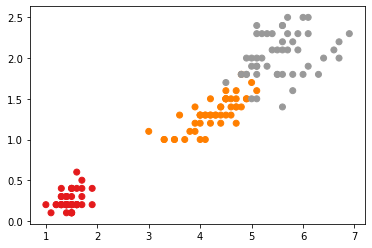

In [146]:
%pylab inline
from matplotlib import pyplot as plt
plt.scatter(X, Y, c=iris.target, cmap=plt.cm.Set1)

In [155]:
from sklearn.decomposition.pca import PCA
clf = PCA(n_components  = 2)
X = clf.fit_transform(iris.data)

In [158]:
clf.components_

array([[ 0.36158968, -0.08226889,  0.85657211,  0.35884393],
       [ 0.65653988,  0.72971237, -0.1757674 , -0.07470647]])

In [152]:
X.shape

(150, 2)

Populating the interactive namespace from numpy and matplotlib


/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


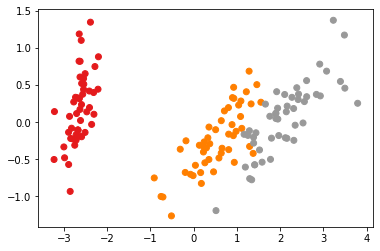

In [151]:
%pylab inline
from matplotlib import pyplot as plt
plt.scatter(X[:,0], X[:,1], c=iris.target, cmap=plt.cm.Set1)

## SVD

In [159]:
from scipy.linalg import svd
U, S, V = svd(iris.data, full_matrices=False)

In [160]:
iris.data.shape

(150, 4)

In [161]:
U.shape

(150, 4)

In [162]:
S.shape

(4,)

In [163]:
V.shape

(4, 4)

In [164]:
S

array([95.95066751, 17.72295328,  3.46929666,  1.87891236])

In [165]:
np.diag(S)

array([[95.95066751,  0.        ,  0.        ,  0.        ],
       [ 0.        , 17.72295328,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  3.46929666,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.87891236]])

In [166]:
A_new = np.dot(U.dot(np.diag(S)), V)

In [168]:
#A_new

In [169]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(2)
X = svd.fit_transform(iris.data)

In [171]:
#X

## 使用 SVD 壓縮圖片

In [172]:
from PIL import Image
im = Image.open('/Users/davidchiu/Desktop/chilin.jpg')

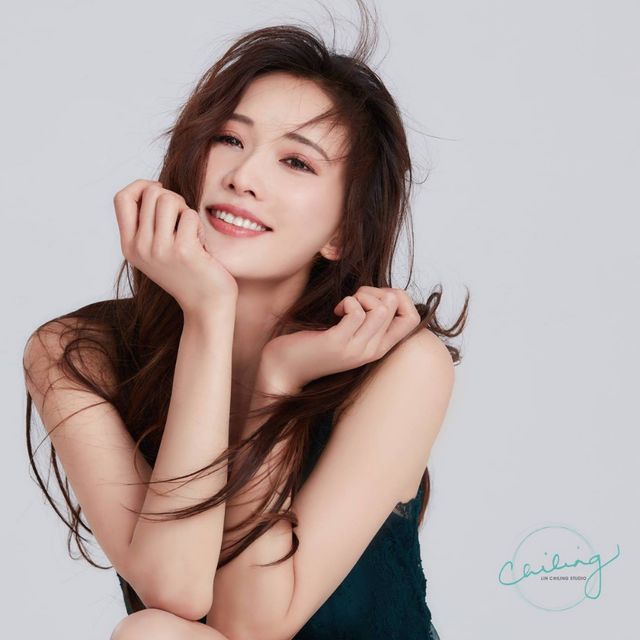

In [173]:
im

In [174]:
import numpy
imgary = numpy.array(im)
imgary = imgary / 255

In [176]:
imgary.shape

(640, 640, 3)

In [177]:
original_bytes = imgary.nbytes
original_bytes


9830400

In [178]:
img_red   = imgary[:, :, 0]
img_green = imgary[:, :, 1]
img_blue  = imgary[:, :, 2]

In [180]:
from numpy.linalg import svd

U_r, S_r, V_r = svd(img_red, full_matrices=True)
U_g, S_g, V_g = svd(img_green, full_matrices=True)
U_b, S_b, V_b = svd(img_blue, full_matrices=True)

In [181]:
U_r.shape, S_r.shape, V_r.shape

((640, 640), (640,), (640, 640))

In [182]:
k = 100

In [183]:
U_r_k = U_r[:, 0:k]
V_r_k = V_r[0:k, :]
U_g_k = U_g[:, 0:k]
V_g_k = V_g[0:k, :]
U_b_k = U_b[:, 0:k]
V_b_k = V_b[0:k, :]

S_r_k = S_r[0:k]
S_g_k = S_g[0:k]
S_b_k = S_b[0:k]

In [184]:
U_r_k.shape, S_r_k.shape, V_r_k.shape

((640, 100), (100,), (100, 640))

In [185]:
compressed_bytes = sum([matrix.nbytes for matrix in 
                        [U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k]])
ratio = compressed_bytes / original_bytes
ratio

0.312744140625

In [186]:

image_red_approx   = np.dot(U_r_k, np.dot(numpy.diag(S_r_k), V_r_k))
image_green_approx = np.dot(U_g_k, np.dot(numpy.diag(S_g_k), V_g_k))
image_blue_approx  = np.dot(U_b_k, np.dot(numpy.diag(S_b_k), V_b_k))

In [188]:

row, col, _ = imgary.shape
img_reconstructed = np.zeros((row, col, 3))

img_reconstructed[:, :, 0] = image_red_approx
img_reconstructed[:, :, 1] = image_green_approx
img_reconstructed[:, :, 2] = image_blue_approx

In [189]:
img_reconstructed[img_reconstructed < 0] = 0
img_reconstructed[img_reconstructed > 1] = 1

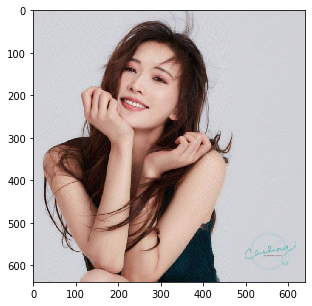

In [190]:
fig = plt.figure(figsize=(10,5))
a = fig.add_subplot(1, 1, 1)
imgplot = plt.imshow(img_reconstructed)

## 將文字資訊進行降維 (SVD)

In [191]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
C =create_co_matrix(corpus, len(word_to_id), 2)

In [192]:
W = ppmi(C)

In [193]:
U, S, V = np.linalg.svd(W)

In [194]:
U.shape, S.shape, V.shape

((7, 7), (7,), (7, 7))

In [196]:
U[:,:2]

array([[-0.29432744, -0.29746118],
       [-0.3710324 ,  0.26495245],
       [-0.31352073,  0.30776066],
       [-0.2670278 , -0.09261478],
       [-0.33312967, -0.30777904],
       [-0.5126197 ,  0.5698161 ],
       [-0.48203   , -0.56445074]], dtype=float32)

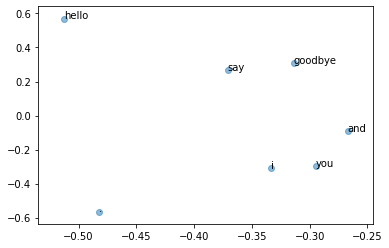

In [198]:
from matplotlib import pyplot as plt
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()


In [199]:
text = '''
Tesla's new Cybertruck smashed during demo
Tesla has unveiled its "Cybertruck" pickup truck, but not without an embarrassing moment on stage.

The truck's windows were smashed during a demonstration supposed to show how hard they were to break.

Mr Musk was heard to swear before joking: "Room for improvement."

The truck was unveiled in Hawthorne, California, where its stainless steel, angular design was greeted with cheers but also bemusement.

"People probably won’t get past the looks of it," said Jessica Caldwell, from vehicle marketplace Edmunds.

"It looks like a truck version of the DeLorean from Back To The Future."

The pickup market represents a significant opportunity for Tesla as it improves its battery technology, meaning carrying heavier loads over long distances is now practical.
According to Edmunds, large trucks have accounted for 14.4% of new vehicle sales up until October this year, compared to 12.6% in 2015. The vehicles have an average selling value of more than $50,000.

Tesla's truck will be sold starting at $39,900 (£30,900), a model which has a range of 250 miles (402km), while the most expensive model, at $69,900, will have a range of 500 miles. The truck will seat up to six adults and haul a payload of 3,500lbs, Tesla said.

Mr Musk said pre-orders would start immediately, with production starting in late 2021 - though the 48-year-old has a history of missing his own deadlines.

The Cybertruck's launch will undoubtedly be overshadowed by the "fail", Ms Caldwell said.

It happened during a segment displaying how the car's stainless steel exterior, and metal windows, could withstand bullets and sledgehammers. However, when Tesla's head of design, Franz von Holzhausen, threw a metal ball at the front left window, it smashed. As too did the rear left.

"It didn’t go through, that’s a plus side," Mr Musk said.

"We threw wrenches, we threw literally the kitchen sink at the glass and it didn’t break. For some reason it broke now… I don’t know why."

At the time of writing, Tesla stock price was mostly unchanged in after-hours trading.
'''

In [200]:
corpus, word_to_id, id_to_word = preprocess(text)
C =create_co_matrix(corpus, len(word_to_id), 2)

In [201]:
W = ppmi(C)

In [202]:
U, S, V = np.linalg.svd(W)

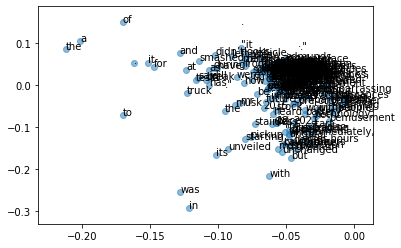

In [203]:
from matplotlib import pyplot as plt
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()


In [204]:
cs = cosine_similarity(U[:,:2],U[:,:2])

In [206]:
cs.shape

(237, 237)

In [212]:
pos = word_to_id['cybertruck']
for ele in cs[pos].argsort()[::-1][1:11]:
    print(id_to_word[ele])

than
payload
500
however,
."

at
it,"
while
left
.4%
why


## 人工神經網路

In [300]:
import numpy as np
X = np.array([20,6,300,2])
W = np.random.random((4,1))
O = np.dot(X,W)

In [301]:
def f(i):
    return i
O2 = f(O)
O2

array([229.96803813])

In [302]:
2000 - O2[0]

1770.031961867567

In [303]:
W = np.array([100, -50, 1, 0])
np.dot(X,W)

2000

In [304]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [305]:
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1
    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1
    return one_hot

In [306]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
    return np.array(contexts), np.array(target)

In [307]:
text

'You say goodbye and I say hello.'

In [308]:
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [309]:
contexts, target = create_contexts_target(corpus, 1)

In [310]:
contexts

array([[0, 2],
       [1, 3],
       [2, 4],
       [3, 1],
       [4, 5],
       [1, 6]])

In [311]:
target

array([1, 2, 3, 4, 1, 5])

In [312]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [313]:
contexts

array([[[1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]],

       [[0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1]]], dtype=int32)

In [314]:
target

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [315]:
c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
h = np.dot(c,W)
print(h)

[[-0.20304755  1.48978961 -0.2225045 ]]


In [316]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx


class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx


class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx


class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx


class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None 
        self.t = None 

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx


class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

In [317]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

In [318]:
def softmax_function(x):
    return np.exp(x) / np.sum(np.exp(x))

In [319]:
in_ary = np.array([3,7,10])
softmax_function(in_ary)

array([8.67881295e-04, 4.73847131e-02, 9.51747406e-01])

In [320]:
contexts

array([[[1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]],

       [[0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1]]], dtype=int32)

In [321]:
target

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [322]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx


class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx


class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx


class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx


class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None 
        self.t = None 

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx


class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

In [323]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

In [324]:
vocab_size = len(word_to_id)
hidden_size = 5
model = SimpleCBOW(vocab_size, hidden_size)

In [325]:
class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

In [326]:
optimizer = Adam()

In [327]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [328]:
def remove_duplicate(params, grads):
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                if params[i] is params[j]:
                    grads[i] += grads[j]  
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

In [329]:
class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
       
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

              
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()

In [330]:
trainer = Trainer(model, optimizer)

In [331]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

In [332]:
window_size = 1
batch_size = 3
max_epoch = 100
trainer.fit(contexts, target, max_epoch, batch_size)

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

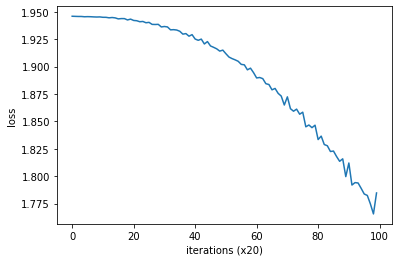

In [333]:
trainer.plot()


In [334]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])


you [ 0.03289481  0.21492422  0.20366178 -0.22606649  0.21531178]
say [-0.2699106   0.24681577 -0.02971628  0.05729116 -0.2704473 ]
goodbye [0.20407131 0.20051731 0.26006317 0.03038748 0.24266446]
and [-0.2489221   0.2171378   0.23336744  0.25474545 -0.24848984]
i [0.21090278 0.21694866 0.25860485 0.03920621 0.2574415 ]
hello [ 0.03933945  0.21559449  0.19990267 -0.23554845  0.21161886]
. [-0.20673133  0.2094742  -0.21651976 -0.21512006 -0.16285518]


In [339]:
from sklearn.metrics.pairwise import euclidean_distances
euclidean_distances(word_vecs)[0].argsort()

array([0, 5, 2, 4, 6, 1, 3])

In [338]:
id_to_word[5]

'hello'

In [340]:
euclidean_distances(word_vecs)[4].argsort()

array([4, 2, 0, 5, 3, 1, 6])

In [341]:
id_to_word[2]

'goodbye'

In [351]:

answer = np.array([0,1,0,0,0,0,0])
predict = softmax_function(np.random.rand(1,7))

In [352]:
predict - answer

array([[ 0.15365408, -0.80949807,  0.16394032,  0.099864  ,  0.09372394,
         0.14013886,  0.15817687]])

In [358]:
def sigmoid_function(x):
    return 1 / (1 + np.exp(-x))

In [360]:
#sigmoid_function(300)

In [356]:
answer = 1
predict = sigmoid_function(np.random.rand(1))

## Gensim

In [361]:
! pip install gensim

You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [364]:
s = 'you say goodby and i say hello .'

from gensim.models import word2vec
model = word2vec.Word2Vec([s.split()], min_count=1, size=3) 

In [365]:
model

In [366]:
model.wv.vectors.shape

(7, 3)

In [367]:
model.wv.vectors

array([[ 0.15580046, -0.04947501, -0.01585815],
       [ 0.10708035,  0.14259274, -0.06324305],
       [ 0.08813638, -0.05700736,  0.0817363 ],
       [-0.1011775 ,  0.0670635 ,  0.10686471],
       [-0.0821751 ,  0.04510653,  0.06381281],
       [-0.01110122, -0.13624045, -0.05866794],
       [-0.08201899, -0.02759126, -0.15634839]], dtype=float32)

In [368]:
model.wv.vocab

{'you': <gensim.models.keyedvectors.Vocab at 0x13ae1e908>,
 'say': <gensim.models.keyedvectors.Vocab at 0x13af4c9b0>,
 'goodby': <gensim.models.keyedvectors.Vocab at 0x13b38e4a8>,
 'and': <gensim.models.keyedvectors.Vocab at 0x13b401160>,
 'i': <gensim.models.keyedvectors.Vocab at 0x13b401198>,
 'hello': <gensim.models.keyedvectors.Vocab at 0x13b4011d0>,
 '.': <gensim.models.keyedvectors.Vocab at 0x13b401208>}

In [369]:
from gensim.models import word2vec
model = word2vec.Word2Vec([s.split()], min_count=1, size=2)

In [370]:
model.wv.vectors

array([[ 0.2337007 , -0.07421251],
       [ 0.16062051,  0.21388912],
       [ 0.13220458, -0.08551104],
       [-0.15176624,  0.10059525],
       [-0.12326264,  0.0676598 ],
       [-0.01665184, -0.20436068],
       [-0.12302849, -0.04138689]], dtype=float32)

Populating the interactive namespace from numpy and matplotlib


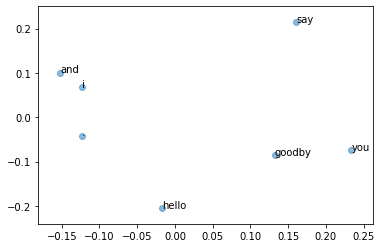

In [372]:
%pylab inline
from matplotlib import pyplot as plt
words = list(model.wv.vocab.keys())
X = model.wv.vectors
for i in range(len(words)):
    plt.annotate(words[i], (X[i, 0], X[i, 1]))
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

In [373]:
text = '''
Tesla's new Cybertruck smashed during demo
Tesla has unveiled its "Cybertruck" pickup truck, but not without an embarrassing moment on stage.

The truck's windows were smashed during a demonstration supposed to show how hard they were to break.

Mr Musk was heard to swear before joking: "Room for improvement."

The truck was unveiled in Hawthorne, California, where its stainless steel, angular design was greeted with cheers but also bemusement.

"People probably won’t get past the looks of it," said Jessica Caldwell, from vehicle marketplace Edmunds.

"It looks like a truck version of the DeLorean from Back To The Future."

The pickup market represents a significant opportunity for Tesla as it improves its battery technology, meaning carrying heavier loads over long distances is now practical.
According to Edmunds, large trucks have accounted for 14.4% of new vehicle sales up until October this year, compared to 12.6% in 2015. The vehicles have an average selling value of more than $50,000.

Tesla's truck will be sold starting at $39,900 (£30,900), a model which has a range of 250 miles (402km), while the most expensive model, at $69,900, will have a range of 500 miles. The truck will seat up to six adults and haul a payload of 3,500lbs, Tesla said.

Mr Musk said pre-orders would start immediately, with production starting in late 2021 - though the 48-year-old has a history of missing his own deadlines.

The Cybertruck's launch will undoubtedly be overshadowed by the "fail", Ms Caldwell said.

It happened during a segment displaying how the car's stainless steel exterior, and metal windows, could withstand bullets and sledgehammers. However, when Tesla's head of design, Franz von Holzhausen, threw a metal ball at the front left window, it smashed. As too did the rear left.

"It didn’t go through, that’s a plus side," Mr Musk said.

"We threw wrenches, we threw literally the kitchen sink at the glass and it didn’t break. For some reason it broke now… I don’t know why."

At the time of writing, Tesla stock price was mostly unchanged in after-hours trading.
'''

In [376]:
from gensim.models import word2vec
model = word2vec.Word2Vec([text.split()], min_count=3, size=5, window=5 )

In [378]:
#model.wv.vectors

In [380]:
model.most_similar('Tesla')

/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('of', 0.7944831252098083),
 ('and', 0.6250981688499451),
 ('The', 0.5881091952323914),
 ('threw', 0.5141059756278992),
 ('it', 0.4859217405319214),
 ('truck', 0.42523229122161865),
 ('the', 0.42041754722595215),
 ('was', 0.3053815960884094),
 ('to', 0.25607115030288696),
 ('Musk', 0.16421346366405487)]

In [384]:
words = nltk.word_tokenize(text)

In [397]:
from gensim.models import word2vec
model = word2vec.Word2Vec([words], min_count=3, size=5, window=5 )

In [400]:
model.most_similar('Tesla')

/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('of', 0.8000127077102661),
 ('and', 0.6394666433334351),
 ('The', 0.6000618934631348),
 ('said', 0.5673915147781372),
 ('threw', 0.5141352415084839),
 ('it', 0.4793822765350342),
 ("'s", 0.44226711988449097),
 ('the', 0.4145381450653076),
 ('truck', 0.41096895933151245),
 ('t', 0.31370556354522705)]

## 使用新聞資料建立模型

In [401]:
import pandas
news = pandas.read_excel('https://raw.githubusercontent.com/ywchiu/pytextmining/master/data/20171214news.xlsx', index_col=0)

In [403]:
news.head(3)

,category,content,link,title
0,政治,新增：立委說法民進黨立法院黨團預計在明天的院會中，讓改制農田水利會的《農田水利會組織通則》修...,https://tw.news.appledaily.com/politics/realti...,【更新】水利會改官派明闖關 綠委24小時前顧議場大門防藍突襲
1,論壇,邱俊棠／台中市民、見習醫師；曾任台灣醫學生聯合會對外副會長對於公民參與公眾事務而能得到單位首...,https://tw.news.appledaily.com/forum/realtime/...,請中市府為所當為 加速中火燃煤限制
2,社會,被控來台涉發展情報組織的中國學生周泓旭，因接觸我方外交部官員而露餡落網，今年9月被台北地院一...,https://tw.news.appledaily.com/local/realtime/...,陸生共諜嗆台司法 「不敢公開審理我」


In [498]:
corpus = []
tags = []
for idx, e in news[news['category'].isin(['社會','娛樂'])].iterrows():
    corpus.append(list(jieba.cut(e['content'])))
    tags.append(e['category'])

In [523]:
from gensim.models import word2vec
model = word2vec.Word2Vec(corpus, min_count=1, size=20, iter=200) 

In [524]:
#model.wv.vocab

In [525]:
model.most_similar('警方')

/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('航警', 0.7725472450256348),
 ('查緝', 0.7647303938865662),
 ('逮捕', 0.7501791715621948),
 ('轄區', 0.7221477627754211),
 ('解剖', 0.6988728046417236),
 ('開槍', 0.6872896552085876),
 ('監視器', 0.6846760511398315),
 ('著實', 0.6819556951522827),
 ('竊盜罪', 0.6750973463058472),
 ('死因', 0.673723578453064)]

In [526]:
model.most_similar('家屬')

/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('拖吊車', 0.8161313533782959),
 ('齊', 0.8077021837234497),
 ('會合', 0.8022601008415222),
 ('楊男', 0.8007879257202148),
 ('機警', 0.785395085811615),
 ('積極', 0.783367395401001),
 ('慰勸', 0.7586366534233093),
 ('協助', 0.7536046504974365),
 ('胞妹', 0.7516741752624512),
 ('如何是好', 0.7410428524017334)]

In [527]:
#model.most_similar('洗錢')

In [529]:
score = np.zeros((1,20))
#score
cnt = 0 
for w in corpus[0]:
    if w in model:
        score += model[w]
        cnt += 1
score / cnt

/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([[ 0.65000378, -0.06782816,  0.16725037,  0.05649241, -0.63560036,
        -0.46508239,  0.0912204 ,  0.13495635,  0.79981255,  1.38688892,
        -0.16019562, -0.99812229, -0.97788925,  0.36526828, -0.85067119,
         0.96181733, -0.46906889, -0.38073617, -0.44881851,  0.39923944]])

In [530]:
size = 20

In [531]:
import numpy as np
vecs = []
vec = np.zeros(size).reshape((1, size))

for s in corpus:
    cnt = 0
    for w in s:
        if w in model:
            #print(w, model[w])
            vec += model[w].reshape((1, size))
            cnt += 1
    vecs.append(vec / cnt)

/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [532]:
len(vecs)

247

In [533]:
X = np.concatenate(vecs, axis = 0)

In [534]:
X.shape

(247, 20)

In [535]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, tags, test_size = 0.2, random_state = 42)

In [540]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
#clf = SVC(kernel='rbf')
clf = GradientBoostingClassifier()
clf.fit(train_X, train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [541]:
predicted = clf.predict(test_X)

In [542]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(test_y, predicted)

0.7

In [543]:
confusion_matrix(test_y, predicted)

array([[13,  9],
       [ 6, 22]])

## 傳統方法

In [490]:
corpus = []
tags = []
for idx, e in news[news['category'].isin(['社會','娛樂'])].iterrows():
    corpus.append(' '.join(jieba.cut(e['content'])))
    tags.append(e['category'])

In [491]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

In [492]:
X.shape

(247, 11380)

In [493]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, tags, test_size = 0.2, random_state = 42)

In [494]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha = 0.01)
clf.fit(train_X, train_y)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [495]:
predicted = clf.predict(test_X)

In [496]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(test_y, predicted)

1.0

In [497]:
confusion_matrix(test_y, predicted)

array([[22,  0],
       [ 0, 28]])

In [545]:
#vectorizer.get_feature_names()

## 文字生成範例

In [546]:
import keras
from keras import layers
import sys
import numpy as np

text= 'this text file can be any text, as long as it contains text longer than maxlen defined below'

chars=['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']

# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)
maxlen=60
step=1

model = keras.models.Sequential()
model.add(layers.LSTM(1024, input_shape=(maxlen, len(chars)),return_sequences=True))
model.add(layers.LSTM(1024, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.load_weights("/Users/davidchiu/course/ctbcpy/data/pre-trained.hdf5")

optimizer = keras.optimizers.Adam(lr=0.0002)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Using TensorFlow backend.
/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/d

In [547]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def random_reviews():
    # sample a start index
    start_index = np.random.randint(0, len(text) - maxlen - 1)
    # the initial sampled text with maxlen long
    generated_text = text[start_index: start_index + maxlen]
    print('Coming up with several reviews for you...')

    for temperature in [0.8]:
        sys.stdout.write(generated_text)

        # We generate 600 characters
        for i in range(600):
            sampled = np.zeros((1, maxlen, len(chars)))
            # Turn each char to char index.
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.
            # Predict next char probabilities
            preds = model.predict(sampled, verbose=0)[0]
            # Add some randomness by sampling given probabilities.
            next_index = sample(preds, temperature)
            # Turn char index to char.
            next_char = chars[next_index]
            # Append char to generated text string
            generated_text += next_char
            # Pop the first char in generated text string.
            generated_text = generated_text[1:]
            # Print the new generated char.
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print(generated_text)

In [549]:
random_reviews()

Coming up with several reviews for you...
his text file can be any text, as long as it contains text leg

/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


end.. dinner and staff.<EOR>"
"<SOR>Amazing food, price is reasonable and the service is great. the salad is always very good and the service is amazing! Thanks for a great experience!   i will always recommend for a non-meat come to the winter when i'm in town!<EOR>"
"<SOR>The perfect place to get drinks and tomatoes, are incredible.                                     s stop sympaliso mit de la soupe !!   an pas de geniee de service et il servir le man la es un resto dans la comida est il montralant top de colo americano de mi richer est excellent<EOR>"
"<SOR>I love this place.            her est excellent<EOR>"
"<SOR>I love this place.            


In [550]:
! pip install bert-extractive-summarizer

You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [551]:
from summarizer import Summarizer

body = '''
The Chrysler Building, the famous art deco New York skyscraper, will be sold for a small fraction of its previous sales price.
The deal, first reported by The Real Deal, was for $150 million, according to a source familiar with the deal.
Mubadala, an Abu Dhabi investment fund, purchased 90% of the building for $800 million in 2008.
Real estate firm Tishman Speyer had owned the other 10%.
The buyer is RFR Holding, a New York real estate company.
Officials with Tishman and RFR did not immediately respond to a request for comments.
It's unclear when the deal will close.
The building sold fairly quickly after being publicly placed on the market only two months ago.
The sale was handled by CBRE Group.
The incentive to sell the building at such a huge loss was due to the soaring rent the owners pay to Cooper Union, a New York college, for the land under the building.
The rent is rising from $7.75 million last year to $32.5 million this year to $41 million in 2028.
Meantime, rents in the building itself are not rising nearly that fast.
While the building is an iconic landmark in the New York skyline, it is competing against newer office towers with large floor-to-ceiling windows and all the modern amenities.
Still the building is among the best known in the city, even to people who have never been to New York.
It is famous for its triangle-shaped, vaulted windows worked into the stylized crown, along with its distinctive eagle gargoyles near the top.
It has been featured prominently in many films, including Men in Black 3, Spider-Man, Armageddon, Two Weeks Notice and Independence Day.
The previous sale took place just before the 2008 financial meltdown led to a plunge in real estate prices.
Still there have been a number of high profile skyscrapers purchased for top dollar in recent years, including the Waldorf Astoria hotel, which Chinese firm Anbang Insurance purchased in 2016 for nearly $2 billion, and the Willis Tower in Chicago, which was formerly known as Sears Tower, once the world's tallest.
Blackstone Group (BX) bought it for $1.3 billion 2015.
The Chrysler Building was the headquarters of the American automaker until 1953, but it was named for and owned by Chrysler chief Walter Chrysler, not the company itself.
Walter Chrysler had set out to build the tallest building in the world, a competition at that time with another Manhattan skyscraper under construction at 40 Wall Street at the south end of Manhattan. He kept secret the plans for the spire that would grace the top of the building, building it inside the structure and out of view of the public until 40 Wall Street was complete.
Once the competitor could rise no higher, the spire of the Chrysler building was raised into view, giving it the title.
'''

model = Summarizer()
result = model(body, min_length=60)
full = ''.join(result)
print(full)

The Chrysler Building, the famous art deco New York skyscraper, will be sold for a small fraction of its previous sales price. The deal, first reported by The Real Deal, was for $150 million, according to a source familiar with the deal. The building sold fairly quickly after being publicly placed on the market only two months ago. The incentive to sell the building at such a huge loss was due to the soaring rent the owners pay to Cooper Union, a New York college, for the land under the building.


In [552]:
text = '''
Tesla's new Cybertruck smashed during demo
Tesla has unveiled its "Cybertruck" pickup truck, but not without an embarrassing moment on stage.

The truck's windows were smashed during a demonstration supposed to show how hard they were to break.

Mr Musk was heard to swear before joking: "Room for improvement."

The truck was unveiled in Hawthorne, California, where its stainless steel, angular design was greeted with cheers but also bemusement.

"People probably won’t get past the looks of it," said Jessica Caldwell, from vehicle marketplace Edmunds.

"It looks like a truck version of the DeLorean from Back To The Future."

The pickup market represents a significant opportunity for Tesla as it improves its battery technology, meaning carrying heavier loads over long distances is now practical.
According to Edmunds, large trucks have accounted for 14.4% of new vehicle sales up until October this year, compared to 12.6% in 2015. The vehicles have an average selling value of more than $50,000.

Tesla's truck will be sold starting at $39,900 (£30,900), a model which has a range of 250 miles (402km), while the most expensive model, at $69,900, will have a range of 500 miles. The truck will seat up to six adults and haul a payload of 3,500lbs, Tesla said.

Mr Musk said pre-orders would start immediately, with production starting in late 2021 - though the 48-year-old has a history of missing his own deadlines.

The Cybertruck's launch will undoubtedly be overshadowed by the "fail", Ms Caldwell said.

It happened during a segment displaying how the car's stainless steel exterior, and metal windows, could withstand bullets and sledgehammers. However, when Tesla's head of design, Franz von Holzhausen, threw a metal ball at the front left window, it smashed. As too did the rear left.

"It didn’t go through, that’s a plus side," Mr Musk said.

"We threw wrenches, we threw literally the kitchen sink at the glass and it didn’t break. For some reason it broke now… I don’t know why."

At the time of writing, Tesla stock price was mostly unchanged in after-hours trading.
'''

In [553]:
model = Summarizer()
result = model(text, min_length=60)
full = ''.join(result)
print(full)

Tesla's new Cybertruck smashed during demo
Tesla has unveiled its "Cybertruck" pickup truck, but not without an embarrassing moment on stage. The truck's windows were smashed during a demonstration supposed to show how hard they were to break. According to Edmunds, large trucks have accounted for 14.4% of new vehicle sales up until October this year, compared to 12.6% in 2015. The Cybertruck's launch will undoubtedly be overshadowed by the "fail", Ms Caldwell said.
